<h1>Preprocessing and Inference of Sentinel 2 downloaded images</h1>

Prerequisites:
- Google Drive account with the downloaded images folder (Sufficient space to save the preprocessed and predicted images - same as input size)


**Input:** A drive Downloaded Sentinel2 GeoTiff images , 11 Bands, 300x300 pixels

**Output:** Preprocessed GeoTiff images (300x300px):
- Preprocessed: 15 bands
- Predicted masks: 1 band 3 classes (0: 0 Other,1: 250 Non-Residential,2: 255 Residential)

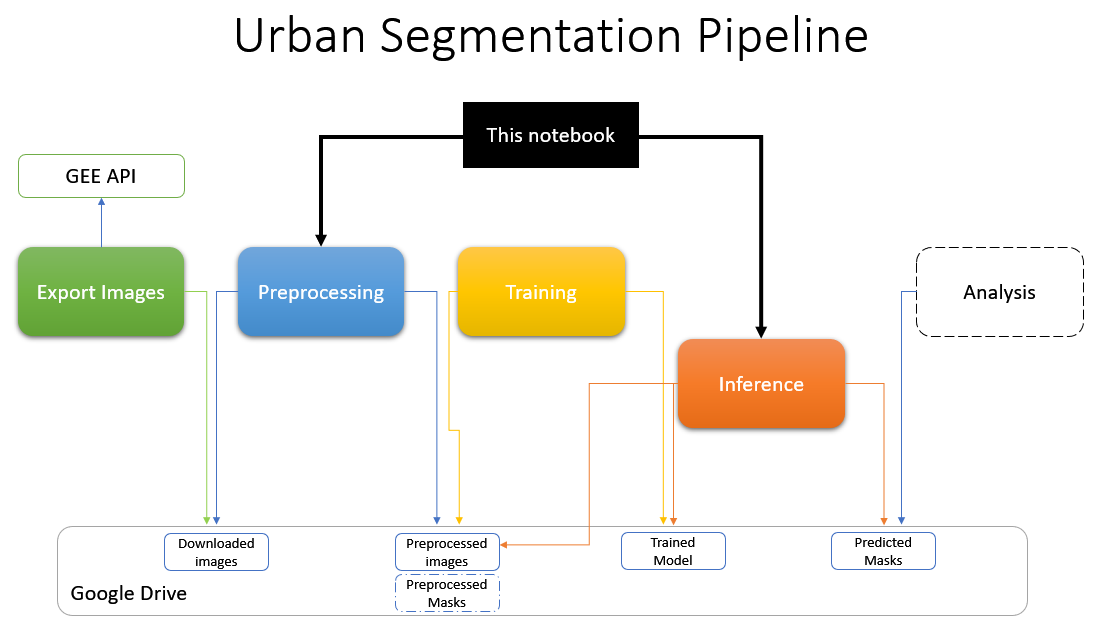

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install rasterio fastai -q torch torchmetrics

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 419 kB 68.6 MB/s 


In [3]:
import os
import sys
import sys
import glob
import torch
import numpy as np
import pprint as pp
import pandas as pd
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Source folder with the downloaded images (CHANGE INPUT AND OUTPUT DIRECTORIES)

A new target folder will be created with the same location and name and suffix **"_prep"**
All the preprocessed images will be placed there

In [5]:
#TODO Change to "True" to see predicted masks (takes a bit longer to run)
VERBOSE=False

#Current working directory
#TODO >>>>>>>>>> CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
NB_DIR = '/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks/'
os.chdir(NB_DIR)
WORK_DIR = NB_DIR+'/../'

# Create a path to the exported folder where the ESM and S2 directories were extracted to
#TODO >>>>>>>>>> CHANGE TO THE DOWNLOADED IMAGES DIRECTORY (INPUT)
EXPORT_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601test'
PREPROC_DIR = EXPORT_DIR + '_prep/'
S2_DIR = EXPORT_DIR
s2_path = Path(S2_DIR)

# This directory is the parent of the "libs" directory which is imported below
sys.path.append(NB_DIR)

#Our implementation (can be called after setting env directories)
from libs.common import *
from libs.bands import *
from libs.training import *
from libs.inference import *

path1 = Path(EXPORT_DIR)
three_files = [f for f in path1.iterdir()][:3]
pprint(three_files)
print('Number of input images:',len(glob.glob(S2_DIR + '/*.tif')))

[PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_1.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_2.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_3.tif')]
Number of input images: 49


## Part 1 - Preprocessing 

In [6]:
CMAP='brg_r'
SAMPLE_IMAGE = three_files[0]
if(VERBOSE):
  s2_sample = display_image(SAMPLE_IMAGE,title=SAMPLE_IMAGE.name)
  print_image_metadata(s2_sample,SAMPLE_IMAGE.name)

In [7]:
NUM_BANDS = 15

bands_dictionary = {
    1:'B1_Blue',
    2:'B2_Green',
    3:'B3_Red',
    4:'B4_Red_Edge_1',
    5:'B5_Red_Edge_2',
    6:'B6_Red_Edge_3',
    7:'B7_NIR',
    8:'B8_Red_Edge_4',
    9:'B9_Water_vapor',
    10:'B10_SWIR_1',
    11:'B11_SWIR_2',
    12:'B12_NDVI', #added in this NB
    13:'B13_NDTI', #added in this NB
    14:'B14_NDVIre', #added in this NB
    15:'B15_MNDWI' #added in this NB
}

## In case the source images names have spaces you can use this to replace it with "_"

In [8]:
#UNCOMMENT to rename
# rename_images(S2_DIR)

In [9]:
#UNCOMMENT if you want to regenerate all images
# !rm -rf {PREPROC_DIR}

## Resizing to 300x300 + adding 4 new bands to the target images

The target folder will be used in the Inference notebook as input

In [10]:
batch_resize(S2_DIR,PREPROC_DIR,n_bands=NUM_BANDS)

Source dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test
Target dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prep/
/content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prep/ Directory exists, exiting(DELETE it and rerun to force regeneration)
49


## Calculating new images per band statistics

In [11]:
stats_mean_df = pd.DataFrame(columns=range(1,NUM_BANDS))
stats_std_df = pd.DataFrame(columns=range(1,NUM_BANDS))

s2_images = glob.glob(PREPROC_DIR+ '/*.tif')
for row,image in tqdm(enumerate(s2_images),total=len(s2_images)):
  with rio.open(image,'r') as im:
    for c in range(1,im.count+1):
      chn=np.array(im.read(c))
      #imputing mean and STD of  exported images with the mean and STD of the other non nans values in the channel
      if(np.isnan(chn).sum()>0):
        not_nan =(np.isnan(chn)==False)
        stats_mean_df.loc[row,c] =  chn[not_nan].mean()
        stats_std_df.loc[row,c] = chn[not_nan].std()
        # print(np.isnan(chn).sum())
      else:
        stats_mean_df.loc[row,c] = chn.mean()
        stats_std_df.loc[row,c] = chn.std()
       


  0%|          | 0/49 [00:00<?, ?it/s]

In [12]:
cp = stats_mean_df.dropna()

len(stats_mean_df),len(cp)

(49, 49)

In [13]:
if(VERBOSE):
  f,axs = plt.subplots(1,3,figsize=(20,6))
  x = np.arange(-0.6, 0.8, 1e-04)
  for i in range(1,NUM_BANDS):
    #Filter some bands
    # if i in [11,12,13,14,15,16]:
    axs[0].plot(x, scipy.stats.norm.pdf(x, stats_mean_df.mean()[i], stats_std_df.mean()[i]),label=i)
      

  stats_mean_df.plot.box(ax=axs[1])
  # stats_mean_df[[12,13,14,15]].plot.box(ax=axs[1])
  axs[1].set_title('Means')
  stats_std_df.plot.box(ax=axs[2])
  # stats_std_df[[12,13,14,15]].plot.box(ax=axs[2])
  axs[2].set_title('Stds')
  axs[0].legend()
  plt.suptitle('Different channels distributions')
  plt.show()

In [14]:
#TODO put these under {PREPROC_DIR}_metadata
stats_mean_df.to_csv('down_stats_mean_df.csv',header=True)
stats_std_df.to_csv('down_stats_std_df.csv',header=True)

### Part 2 - Inference

**Predicted Classes**

Originally we have 4 classes in the input images:
- 250 for non-residential **(Red)**
- 255 for residential     **(Blue)**
- 1 for all other areas   **(Green , merged into 0)**
- 0 for no data           **(Green also)**

We turn them to a sequence 0 to 3 for the segmentation to work properly:
codes decoder dictionary (0,1,2,3)->(0,1,250,255)

After many experiments we merged the 0 and 1 classes into 0 - which is the "background" class

In [15]:
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}
else:
  code2class = {0:0,1:1,2:250,3:255}
  class2code={0:0,1:1,250:2,255:3}
  class2desc={0:'No Data',1:'Other',250:'Non Resi',255:'Resi'}

Show 2 samples , normalized and RGB with and without augmentations

The augmented images may look the same as the original, depending on the augmentation probability (default 0.2) 


## Loading trained UNET model

Best UNet model Mean Dice score:0.83

In [16]:
n_channels = NUM_BANDS
n_classes=len(class2code)
model_unet = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)

In [17]:
%%time

clear_cache()

def load_pretrained():
    model_unet.load_state_dict(torch.load(FINAL_MODEL_PATH),strict=False)
    print('loaded model from:',FINAL_MODEL_PATH)
    return model_unet.to(device)
    
FINAL_MODEL_PATH=NB_DIR +'../models/final_model.pth'
final_states_dict_file = Path(FINAL_MODEL_PATH)
INFERECE_MODE=final_states_dict_file.is_file()

print('Inference mode: loading model states dict...')
model_unet = load_pretrained()


Inference mode: loading model states dict...
loaded model from: /content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks/../models/final_model.pth
CPU times: user 1.13 s, sys: 602 ms, total: 1.74 s
Wall time: 8.26 s


In [18]:

test2_images = load_tif_files(PREPROC_DIR,'Downloaded')
TARGET_PREDS_DIR = '/content/target_preds'
!rm -rf {TARGET_PREDS_DIR}
!mkdir -p {TARGET_PREDS_DIR}

Downloaded - 49 image files in /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prep/


In [19]:
%%time

test2_ds  = S2OnlyDataset(test2_images)
test2_dl = torch.utils.data.DataLoader(test2_ds, batch_size=1, shuffle=False)
print(len(test2_dl),'batches,',len(test2_ds),'images')

  0%|          | 0/49 [00:00<?, ?it/s]

49 batches, 49 images
CPU times: user 1.89 s, sys: 301 ms, total: 2.19 s
Wall time: 2.57 s


In [20]:
clear_cache()

test2_preds = predict(model_unet,test2_dl,device)

  0%|          | 0/49 [00:00<?, ?it/s]

In [21]:
flat2_preds = [x for xs in test2_preds for x in xs]
print(len(test2_images),len(flat2_preds))
plot_predictions(test2_images,flat2_preds,PREPROC_DIR,
                 TARGET_PREDS_DIR,cmap=CMAP,code2class=code2class,
                 class2desc=class2desc,show_every=9,verbose=VERBOSE)

49 49


  0%|          | 0/49 [00:00<?, ?it/s]

pred masks saved to: /content/target_preds


In [22]:
#Change to True in order to backup predictions to drive
BACKUP=False
if(BACKUP):
  print('Uploading images to:',WORK_DIR)
  !cp -rf {TARGET_PREDS_DIR} WORK_DIR
  !cp -rf {PREDS_DIR} WORK_DIR
print('Predictions saved to:',TARGET_PREDS_DIR)

Predictions saved to: /content/target_preds


In [23]:
if(VERBOSE):
  SAITAMA = TARGET_PREDS_DIR
  sait = glob.glob(os.path.join(SAITAMA,'*.tif'))
  sait = sorted(sait)
  print(len(sait))
  f,axs = plt.subplots(7,7,figsize=(25,25))
  im_no = 0
  for i in range(7):
    for j in range(7):
      a = show_image(sait[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j])
      axs[i,j].axes.xaxis.set_visible(False)
      axs[i,j].axes.yaxis.set_visible(False)
      im_no+=1
  plt.axis("off")
  plt.tight_layout()
  plt.show()